In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # mean centering
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        # covariance, functions needs samples as columns
        cov = np.cov(X.T)

        # eigenvectors, eigenvalues
        eigenvectors, eigenvalues = np.linalg.eig(cov)

        # eigenvectors v = [:, i] column vector, transpose this for easier calculations
        eigenvectors = eigenvectors.T

        # sort eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, X):
        # projects data
        X = X - self.mean
        return np.dot(X, self.components.T)

In [ ]:
class MyFuzzy:

  def __init__(self, C=None, m=1.5):
    self.C = C
    self.m = m
    self.clusters_centroid = None

  def fit(self, X, C=None, m=1.5, epochs=20):
    self.m = m
    if C is not None:
      self.C = C

    # get random data points to be centroids
    v_cluster_centers = X[np.random.choice(X.shape[0], size=self.C)]

    distances = None
    u_memberships = None

    for e in tqdm(range(epochs)):
      # step 1 calculate distance matrix
      distances = self.calculate_distance_matrix(X, v_cluster_centers)

      # step 2 calculate membership function
      u_memberships = self.calculate_membership_matrix(distances, self.m)

      # step 3 calculate new clusters' centroid
      k = np.power(u_memberships, self.m)
      r = k[:,:,np.newaxis]*X[:,np.newaxis]
      r = np.sum(r, axis=0)
      k = np.sum(k, axis=0)
      v_cluster_centers = r/k[:,np.newaxis]
    self.clusters_centroid = v_cluster_centers


  def calculate_distance_matrix(self, X, cluster_centers):
      distances = X[:,np.newaxis] - cluster_centers[np.newaxis] + 1e-9
      distances = np.sum(distances**2, axis=2)
      distances = np.sqrt(distances)
      return distances

  def calculate_membership_matrix(self, distances, m):
      r = np.power(distances, -2/(m-1))
      k = np.sum(r, axis=1)
      k = np.power(k, -1)
      u_memberships = r*k[:,np.newaxis]
      return u_memberships

  def soft_predict(self, X):
    n = X.shape[0]

    distances = self.calculate_distance_matrix(X, self.clusters_centroid)
    u_memberships = self.calculate_membership_matrix(distances, self.m)

    return u_memberships


  def predict(self, X):
    return self.soft_predict(X).argmax(axis=-1)

  def accuracy(self, Y_true, Y_pred):
    c = 0
    for i in range(len(Y_pred)):
      if Y_pred[i] == Y_true[i]:
        c+=1
    acc = c/len(Y_pred) * 100
    return max(100-acc,acc) 

In [ ]:
data = './BankNote_Authentication.csv'
df = pd.read_csv(data)

In [ ]:
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


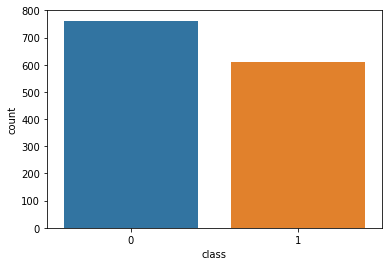

In [ ]:
sns.countplot(data=df, x='class')

In [ ]:
# All data are numbers there is no null or missed values
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [ ]:
df.shape

(1372, 5)

In [ ]:
X = df.drop(['class'], axis=1).to_numpy()
y = df['class'].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# Apply Fuzzy-C-Means before PCA
model = MyFuzzy(C=2, m=1.25)
model.fit(X_train, epochs=50)

100%|██████████| 50/50 [00:00<00:00, 1058.52it/s]


In [ ]:
Y_pred = model.predict(X_test)
acc = model.accuracy(Y_pred, y_test)
print('accuracy before pca ', acc)

accuracy before pca  60.19417475728155


In [ ]:
# Apply PCA
pca = PCA(2)
pca.fit(X)

In [ ]:
X_projected = pca.transform(X)
print(X_projected.shape)
print(X_projected[:5])

(1372, 2)
[[ 331.05361096  216.78236911]
 [ 300.07351436  254.47259888]
 [-206.41434997  135.52649275]
 [ 338.91582833  200.35050537]
 [-302.493687    -57.42774506]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size=0.3)

In [ ]:
# after applying pca
model = MyFuzzy(C=2, m=1.25)
model.fit(X_train, epochs=50)

100%|██████████| 50/50 [00:00<00:00, 983.76it/s]


In [ ]:
Y_pred = model.predict(X_test)
acc = model.accuracy(Y_pred, y_test)
print('accuracy after pca ', acc)

accuracy after pca  76.2135922330097
